In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import date
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from matplotlib import colors

### Create regression data

In [74]:
tfidf_path = '../../data/tfidf_toprev_samplew_allave/'

In [75]:
lda_path = '../../data/lda_jsd_toprev_conlen/'

In [76]:
tag_path = '../../data/tag_novelty_full/'

In [77]:
fandom_list = ['harry_potter',
 'dcu',
 'doctor_who_&_related_fandoms',
 'star_wars_all_media_types',
 'arthurian_mythology_&_related_fandoms',
 'supernatural',
 'haikyuu',
 'kuroko_no_basuke',
 'hamilton_miranda',
 'dragon_age_all_media_types',
 'the_walking_dead_&_related_fandoms',
 'buffy_the_vampire_slayer',
 'les_miserables_all_media_types',
 'naruto',
 'tolkien_j_r_r_works_&_related_fandoms',
 'shakespare_william_works',
 'hetalia_axis_powers',
 'attack_on_titan',
 'ms_paint_adventures',
 'homestuck',
 'marvel',
 'bishoujo_senshi_sailor_moon',
 'one_direction',
 'sherlock_holmes_&_related_fandoms']

In [78]:
def first_rel(field):
    try:
        return field.split(',')[0]
    except:
        return field

In [79]:
def find_major_rel(df):
    df['Relationship'] = df.apply(lambda row: first_rel(row['Relationship']), axis=1)
    counts = df['Relationship'].value_counts()
    return counts.keys()[0:5]


In [81]:
df_all = []
for i,fandom in enumerate(fandom_list):
    df_tfidf = pd.read_csv(os.path.join(tfidf_path,fandom + '_temporal_tfidf_cos_toprev_conlen_allave.tsv'), sep = '\t')
    del df_tfidf['index']
    df_lda = pd.read_csv(os.path.join(lda_path,fandom + '_temporal_lda_jsd_toprev_full.tsv'), sep = '\t')
    del df_lda['index']
    df_tag = pd.read_csv(os.path.join(tag_path,fandom + '_tag_novelty_conlen_full.tsv'), sep = '\t')
    df = pd.merge(df_tfidf, df_lda, on=['AdditionalTags', 'ArchiveWarnings', 'Author', 'Bookmarks', 'Category',\
 'ChapterIndex', 'Chapters' ,'Characters','Comments' ,'CompleteDate',\
 'Fandoms', 'Hits' ,'Kudos', 'Language', 'Notes' ,'PublishDate' ,'Rating',\
 'Relationship' ,'Summary' ,'Title' ,'URL' ,'UpdateDate' ,'Words'], how='inner')
    
    df['fandom_category'] = fandom
    
#     df = df.replace([np.inf, -np.inf], np.nan)
#     df['Hits'].fillna(0, inplace=True)
#     df['Kudos'].fillna(0, inplace=True)
#     df['Bookmarks'].fillna(0, inplace=True)
#     df['Comments'].fillna(0, inplace=True)

#     df['Kudos'] = df['Kudos']/df['Chapters']
#     df = df.replace([np.inf, -np.inf], np.nan)
#     df['Kudos'].dropna()
#     df['Kudos'] = np.log(df['Kudos']+0.001)
#     df['Kudos'] = df['Kudos'].replace([np.inf, -np.inf], np.nan)
#     df['Kudos'] = (df['Kudos'] - df['Kudos'].mean())/df['Kudos'].std(ddof=0)
    
#     df['Hits'] = df['Hits']/df['Chapters']
#     df = df.replace([np.inf, -np.inf], np.nan)
#     df['Hits'].dropna()
#     df['Hits'] = np.log(df['Hits']+0.001)
#     df['Hits'] = (df['Hits'] - df['Hits'].mean())/df['Hits'].std(ddof=0)
    
#     df['Comments'] = np.log(df['Comments']+1)
#     df = df.replace([np.inf, -np.inf], np.nan)
#     df['Comments'] = (df['Comments'] - df['Comments'].mean())/df['Comments'].std(ddof=0)
    
#     df['Bookmarks'] = df['Bookmarks']/df['Chapters']
#     df = df.replace([np.inf, -np.inf], np.nan)
#     df['Bookmarks'] = np.log(df['Bookmarks']+0.001)
#     df['Bookmarks'] = (df['Bookmarks'] - df['Bookmarks'].mean())/df['Bookmarks'].std(ddof=0)

    
    freq_rel = find_major_rel(df)
    df['Relationship'] = df['Relationship'].apply(lambda x: first_rel(x))
    df['Freq_relationship'] = df['Relationship'].apply(lambda x: 1 if x in freq_rel else 0)
    del df['Relationship']
    df_all.append(df)
    

In [82]:
df_all = pd.concat(df_all)

In [83]:
len(df_all)

60443

In [85]:
# df_all = df.head(500)

In [86]:
del df_all['Language']
del df_all['Notes']
del df_all['Summary']
del df_all['Title']
del df_all['URL']
del df_all['AdditionalTags']
del df_all['Fandoms']
del df_all['Characters']
del df_all['Words']

In [87]:
df_all['Category'].fillna('Unknown', inplace=True)
df_all['Category_F_F'] = df_all['Category'].apply(lambda x: 1 if 'F/F' in x else 0)
df_all['Category_F_M'] = df_all['Category'].apply(lambda x: 1 if 'F/M' in x else 0)
df_all['Category_Gen'] = df_all['Category'].apply(lambda x: 1 if 'Gen' in x else 0)
df_all['Category_M_M'] = df_all['Category'].apply(lambda x: 1 if 'M/M' in x else 0)
df_all['Category_Multi'] = df_all['Category'].apply(lambda x: 1 if 'Multi' in x else 0)
df_all['Category_Other'] = df_all['Category'].apply(lambda x: 1 if 'Other' in x else 0)
df_all['Category_Unknown'] = df_all['Category'].apply(lambda x: 1 if 'Unknown' in x else 0)
del df_all['Category']

In [88]:
df_all['ArchiveWarnings_underage'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Underage' in x else 0)
df_all['ArchiveWarnings_death'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Major Character Death' in x else 0)
df_all['ArchiveWarnings_choose_no'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Creator Chose Not To Use Archive Warnings' in x else 0)
df_all['ArchiveWarnings_no_apply'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'No Archive Warnings Apply' in x else 0)
df_all['ArchiveWarnings_violence'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Graphic Depictions Of Violence' in x else 0)
df_all['ArchiveWarnings_noncon'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Rape/Non-Con' in x else 0)

del df_all['ArchiveWarnings']

In [89]:
# df_all = df_all[df_all['ArchiveWarnings_blood'] != 1]
# df_all = df_all[df_all['ArchiveWarnings_none'] != 1]

In [90]:
df_all['ChapterIndex'].fillna(0, inplace=True)

In [91]:
df_all['Author'].fillna('Unknown', inplace=True)
counts = df_all['Author'].value_counts()
idx = counts[counts >= 10].index
df_all['author_fic_cnt'] = df_all['Author'].apply(lambda x: counts[x])
del df_all['Author']

In [92]:
set(df['Rating'].tolist())

{'Explicit',
 'General Audiences',
 'Mature',
 'Not Rated',
 'Teen And Up Audiences'}

In [93]:
df_all['Rating_E'] = df_all['Rating'].apply(lambda x: 1 if x == 'Explicit' else 0)
df_all['Rating_G'] = df_all['Rating'].apply(lambda x: 1 if x == 'General Audiences' else 0)
df_all['Rating_M'] = df_all['Rating'].apply(lambda x: 1 if x == 'Mature' else 0)
df_all['Rating_N'] = df_all['Rating'].apply(lambda x: 1 if x == 'Not Rated' else 0)
df_all['Rating_T'] = df_all['Rating'].apply(lambda x: 1 if x == 'Teen And Up Audiences' else 0)
del df_all['Rating']

In [94]:
df_all['Fandom_harry_potter'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'harry_potter' else 0)
df_all['Fandom_dcu'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'doctor_who_&_related_fandoms' else 0)
df_all['Fandom_doctor_who'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'doctor_who_&_related_fandoms' else 0)
df_all['Fandom_star_wars'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'star_wars_all_media_types' else 0)
df_all['Fandom_arthurian'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'arthurian_mythology_&_related_fandoms' else 0)
df_all['Fandom_supernatural'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'supernatural' else 0)
df_all['Fandom_haikyuu'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'haikyuu' else 0)
df_all['Fandom_kuroko_no_basuke'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'kuroko_no_basuke' else 0)
df_all['Fandom_hamilton_miranda'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'hamilton_miranda' else 0)
df_all['Fandom_dragon_age'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'dragon_age_all_media_types' else 0)
df_all['Fandom_the_walking_dead'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'the_walking_dead_&_related_fandoms' else 0)
df_all['Fandom_buffy'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'buffy_the_vampire_slayer' else 0)
df_all['Fandom_les_miserables'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'les_miserables_all_media_types' else 0)
df_all['Fandom_naruto'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'naruto' else 0)
df_all['Fandom_tolkien'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'tolkien_j_r_r_works_&_related_fandoms' else 0)
df_all['Fandom_shakespare'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'shakespare_william_works' else 0)
df_all['Fandom_hetalia'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'hetalia_axis_powers' else 0)
df_all['Fandom_attack_on_titan'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'attack_on_titan' else 0)
df_all['Fandom_ms_paint_adventures'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'ms_paint_adventures' else 0)
df_all['Fandom_homestuck'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'homestuck' else 0)
df_all['Fandom_marvel'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'marvel' else 0)
df_all['Fandom_sailor_moon'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'bishoujo_senshi_sailor_moon' else 0)
df_all['Fandom_one_direction'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'one_direction' else 0)
df_all['Fandom_sherlock'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'sherlock_holmes_&_related_fandoms' else 0)

del df_all['fandom_category']

In [95]:
def date_today(cell):
    try:
        y, m, d = cell.split('-')
        return abs(date.today() - date(int(y), int(m), int(d))).days
    except:
        return float('nan')

In [96]:
df_all['PublishDate'] = df_all.apply(lambda row: date_today(row['PublishDate']), axis = 1)
df_all['CompleteDate'] = df_all.apply(lambda row: date_today(row['CompleteDate']), axis = 1)
df_all['UpdateDate'] = df_all.apply(lambda row: date_today(row['UpdateDate']), axis = 1)

In [97]:
def find_history(field_list):
    field_list = [10000000 if np.isnan(x) else x for x in field_list]
    return np.amin(field_list)

In [98]:
df_all['history'] = df_all.apply(lambda row: find_history([row['PublishDate'], row['CompleteDate'], row['UpdateDate']]), axis=1)

In [99]:
del df_all['PublishDate']
del df_all['CompleteDate']
del df_all['UpdateDate']

In [100]:
df_all = df_all.replace([np.inf, -np.inf], np.nan)

In [101]:
df_all = df_all.dropna()

In [102]:
len(df_all)

58361

In [103]:
df_all.columns.values

array(['Bookmarks', 'ChapterIndex', 'Chapters', 'Comments', 'Hits',
       'Kudos', 'Cos', 'JSD', 'Freq_relationship', 'Category_F_F',
       'Category_F_M', 'Category_Gen', 'Category_M_M', 'Category_Multi',
       'Category_Other', 'Category_Unknown', 'ArchiveWarnings_underage',
       'ArchiveWarnings_death', 'ArchiveWarnings_choose_no',
       'ArchiveWarnings_no_apply', 'ArchiveWarnings_violence',
       'ArchiveWarnings_noncon', 'author_fic_cnt', 'Rating_E', 'Rating_G',
       'Rating_M', 'Rating_N', 'Rating_T', 'Fandom_harry_potter',
       'Fandom_dcu', 'Fandom_doctor_who', 'Fandom_star_wars',
       'Fandom_arthurian', 'Fandom_supernatural', 'Fandom_haikyuu',
       'Fandom_kuroko_no_basuke', 'Fandom_hamilton_miranda',
       'Fandom_dragon_age', 'Fandom_the_walking_dead', 'Fandom_buffy',
       'Fandom_les_miserables', 'Fandom_naruto', 'Fandom_tolkien',
       'Fandom_shakespare', 'Fandom_hetalia', 'Fandom_attack_on_titan',
       'Fandom_ms_paint_adventures', 'Fandom_homestuc

In [104]:
df_all = df_all.rename(columns = {'history':'History', 'Cos': 'Term_novelty', 'JSD': 'Topic_novelty'})

In [105]:
df_all.head()

,Bookmarks,ChapterIndex,Chapters,Comments,Hits,Kudos,Term_novelty,Topic_novelty,Freq_relationship,Category_F_F,...,Fandom_shakespare,Fandom_hetalia,Fandom_attack_on_titan,Fandom_ms_paint_adventures,Fandom_homestuck,Fandom_marvel,Fandom_sailor_moon,Fandom_one_direction,Fandom_sherlock,History
0,4,15.0,41,0,928.0,19.0,0.917318,0.609569,0,0,...,0,0,0,0,0,0,0,0,0,2259.0
1,4,14.0,41,0,928.0,19.0,0.908760,0.647729,0,0,...,0,0,0,0,0,0,0,0,0,2259.0
2,4,6.0,41,0,928.0,19.0,0.906490,0.600268,0,0,...,0,0,0,0,0,0,0,0,0,2259.0
3,2,0.0,1,2,1963.0,26.0,0.763119,0.646811,1,0,...,0,0,0,0,0,0,0,0,0,2343.0
4,11,22.0,23,0,1860.0,51.0,0.801765,0.598763,0,0,...,0,0,0,0,0,0,0,0,0,1967.0


In [106]:
df_all.to_csv('fanfic_regression_data_curated.tsv', sep = '\t', index=False)

In [107]:
len(df_all)

58361

### Correlations

In [42]:
df_all = pd.read_csv('fanfic_regression_data_curated.tsv', sep = '\t')

In [43]:
df_all = df_all.rename(columns = {'History': 'Age', 'author_fic_cnt':'Author fiction count',\
                                  'Term_novelty': 'Term novelty', 'Topic_novelty':'Topic novelty'})

In [66]:
term_ave = np.average(df_all['Term novelty'])
topic_ave = np.average(df_all['Topic novelty'])
df_all['Term novelty'] = df_all['Term novelty'] - term_ave
df_all['Topic novelty'] = df_all['Topic novelty'] - topic_ave
df_all['Term novelty squared'] = np.square(df_all['Term novelty'])
df_all['Topic novelty squared'] = np.square(df_all['Topic novelty'])

In [67]:
df_all['Term novelty'].head()

0    0.337461
1   -0.196949
2    0.305098
3    0.155515
4    0.181688
Name: Term novelty, dtype: float64

In [68]:
df_all['Term novelty squared'].head()

0    0.113880
1    0.038789
2    0.093085
3    0.024185
4    0.033011
Name: Term novelty squared, dtype: float64

In [69]:
term_sq_ave

0.38452404178795113

In [70]:
df_all['Term novelty squared'].head()

0    0.113880
1    0.038789
2    0.093085
3    0.024185
4    0.033011
Name: Term novelty squared, dtype: float64

In [71]:
np.corrcoef(df_all['Term novelty'], df_all['Term novelty squared'])

array([[ 1.        , -0.07493726],
       [-0.07493726,  1.        ]])

In [72]:
corr = df_all[['Kudos','Bookmarks', 'Comments', 'Hits','Chapters', 'Author fiction count', 'Term novelty', 'Topic novelty', 'Term novelty squared', 'Topic novelty squared','Age']].corr()

In [73]:
corr

,Kudos,Bookmarks,Comments,Hits,Chapters,Author fiction count,Term novelty,Topic novelty,Term novelty squared,Topic novelty squared,Age
Kudos,1.000000,0.715729,0.338296,0.798946,-0.094954,-0.005213,-0.056259,-0.043916,0.008421,0.024190,0.046366
Bookmarks,0.715729,1.000000,0.417094,0.634013,-0.093631,-0.004965,-0.056281,-0.060374,0.001541,0.035586,0.068434
Comments,0.338296,0.417094,1.000000,0.319370,0.089347,-0.008072,-0.074653,-0.065564,0.028263,0.032066,-0.055236
Hits,0.798946,0.634013,0.319370,1.000000,-0.098320,0.012120,-0.044989,-0.045728,-0.009928,0.028970,0.131372
Chapters,-0.094954,-0.093631,0.089347,-0.098320,1.000000,0.010421,-0.002964,0.019393,0.026734,-0.016977,-0.118477
Author fiction count,-0.005213,-0.004965,-0.008072,0.012120,0.010421,1.000000,0.012048,0.004063,0.008170,-0.002505,0.052526
Term novelty,-0.056259,-0.056281,-0.074653,-0.044989,-0.002964,0.012048,1.000000,0.103160,-0.074937,-0.040612,0.064352
Topic novelty,-0.043916,-0.060374,-0.065564,-0.045728,0.019393,0.004063,0.103160,1.000000,-0.019384,-0.561095,0.063814
Term novelty squared,0.008421,0.001541,0.028263,-0.009928,0.026734,0.008170,-0.074937,-0.019384,1.000000,0.003985,-0.107184
Topic novelty squared,0.024190,0.035586,0.032066,0.028970,-0.016977,-0.002505,-0.040612,-0.561095,0.003985,1.000000,0.032160


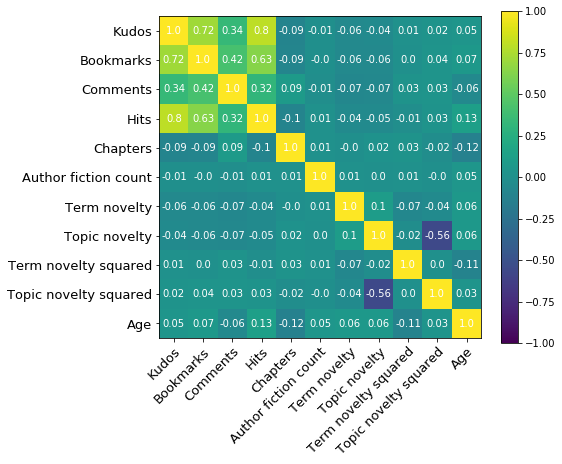

In [74]:
labels = corr.columns.values
fig, ax = plt.subplots(figsize = (8,8))

# kmin = np.amin(corr.as_matrix())
# kmax = np.amax(corr.as_matrix())

norm = colors.Normalize(vmin = -1, vmax = 1)
im = ax.imshow(corr, norm=norm)

# We want to show all ticks...
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", fontsize='13')

plt.setp(ax.get_yticklabels(), fontsize='13')

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, round(corr.as_matrix()[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("")
fig.colorbar(im, shrink=0.7)
fig.tight_layout()
plt.savefig('variables_corr.pdf', format='pdf')

In [26]:
cmap = sns.diverging_palette(5, 250, as_cmap=True)
plt.figure(figsize = (8,6))

corr_plt = sns.heatmap(corr, cmap=cmap, annot=True cbar_kws={'Normalize':clip=False))
plt.tight_layout()
# plt.savefig('variables_corr.pdf', format='pdf')

SyntaxError: invalid syntax (<ipython-input-26-8be6f2364c2f>, line 4)